In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/obesity')
from obesity.snp_encoding_traintest_split import snp_fast_encoding_and_labeling_p
from obesity.model import dense_model
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
train_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210611_1/train_001_snp_obesity_SNP_12234_#_4274.tsv'
train_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210611_1/train_001_snp_normal_SNP_12234_#_32609.tsv'
valid_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210611_1/valid_001_snp_obesity_SNP_12234_#_506.tsv'
valid_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210611_1/valid_001_snp_normal_SNP_12234_#_3648.tsv'
test_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210611_1/test_001_snp_obesity_SNP_12234_#_61.tsv'
test_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210611_1/test_001_snp_normal_SNP_12234_#_383.tsv'

In [4]:
train_data, train_labels = snp_fast_encoding_and_labeling_p(train_normal_snp_data_path, train_obesity_snp_data_path,balance=False,phenotype=False)
valid_data, valid_labels = snp_fast_encoding_and_labeling_p(valid_normal_snp_data_path, valid_obesity_snp_data_path,balance=False,phenotype=False)
#test_data, test_labels = snp_fast_encoding_and_labeling(test_normal_snp_data_path, test_obesity_snp_data_path)

In [5]:
from tensorflow.keras.utils import to_categorical
train_data_onehot = to_categorical(train_data)
valid_data_onehot = to_categorical(valid_data)

In [6]:
valid_data_onehot.shape

(4154, 12234, 11)

In [7]:
from tensorflow.keras.layers import Concatenate, BatchNormalization
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout,Softmax
from tensorflow.keras.layers import Embedding,Reshape
from tensorflow.keras.layers import Input,Flatten
from tensorflow.keras.layers import LeakyReLU,RepeatVector
from tensorflow.keras import Model
from tensorflow.keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses

class Autoencoder(tf.keras.Model):
    def __init__(self,train_data):
        super().__init__()
        n_cols = train_data.shape[1]
        input_ = Input(shape=(n_cols,11))
        #Input layer
        # e = Embedding(11, 8)(input_)
        e = Flatten()(input_)
        #Encodeing
        x = BatchNormalization(center=False,scale=False)(LeakyReLU()(Dense(256)(e)))
        embedding = BatchNormalization(center=False,scale=False,name='embedding')(LeakyReLU()(Dense(128)(x)))
        #Decoding
        x = BatchNormalization(center=False,scale=False)(LeakyReLU()(Dense(256)(embedding)))
        x = Dense(n_cols*11, activation='linear')(x)
        x = Reshape((n_cols,11))(x)
        output_ = Softmax(axis=2)(x)
        self.model = tf.keras.Model(input_,output_)
        self.build((1,n_cols,11))
    
    def summary(self,show_detail=False):
        if show_detail:
            return self.model.summary()
        else: 
            return super().summary()
        
    def call(self, inputs, training=None):
        x = self.model(inputs,training)     
        return x

In [8]:
e = Autoencoder(train_data_onehot)
e.summary(show_detail=True)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12234, 11)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 134574)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               34451200  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)              

In [9]:
best_weights_filepath = 'model/autoencoder_991_001.h5'
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                              patience=50,verbose=1)
e_s = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=150,
                                      verbose=0, mode='min')
saveBestModel = tensorflow.keras.callbacks.ModelCheckpoint(best_weights_filepath, 
                                                        monitor='val_loss', 
                                                        verbose=1, 
                                                        save_best_only=True, 
                                                        mode='auto')

In [10]:
e.model.compile(optimizer = optimizers.Adam(lr=1e-5), loss=losses.CategoricalCrossentropy())
e.model.fit(train_data_onehot,train_data_onehot,
            batch_size= 5,epochs=100,
            shuffle=True,
            validation_data=(valid_data_onehot, valid_data_onehot),
            callbacks=[reduce_lr, e_s,saveBestModel])

Epoch 1/100
7374/7377 [============================>.] - ETA: 0s - loss: 2.3003
Epoch 00001: val_loss improved from inf to 2.19807, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 120s 16ms/step - loss: 2.3003 - val_loss: 2.1981
Epoch 2/100
7374/7377 [============================>.] - ETA: 0s - loss: 2.1603
Epoch 00002: val_loss improved from 2.19807 to 2.06807, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 117s 16ms/step - loss: 2.1603 - val_loss: 2.0681
Epoch 3/100
7376/7377 [============================>.] - ETA: 0s - loss: 2.0452
Epoch 00003: val_loss improved from 2.06807 to 1.96153, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 2.0452 - val_loss: 1.9615
Epoch 4/100
7376/7377 [============================>.] - ETA: 0s - loss: 1.9388
Epoch 00004: val_loss improved from 1.96153 to 1.85257, saving model to model/autoencoder_991_001.h

Epoch 31/100
7375/7377 [============================>.] - ETA: 0s - loss: 0.6288
Epoch 00031: val_loss improved from 0.61160 to 0.60171, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 125s 17ms/step - loss: 0.6288 - val_loss: 0.6017
Epoch 32/100
7374/7377 [============================>.] - ETA: 0s - loss: 0.6185
Epoch 00032: val_loss improved from 0.60171 to 0.59279, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 129s 17ms/step - loss: 0.6185 - val_loss: 0.5928
Epoch 33/100
7374/7377 [============================>.] - ETA: 0s - loss: 0.6097
Epoch 00033: val_loss improved from 0.59279 to 0.58371, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 131s 18ms/step - loss: 0.6097 - val_loss: 0.5837
Epoch 34/100
7375/7377 [============================>.] - ETA: 0s - loss: 0.6015
Epoch 00034: val_loss improved from 0.58371 to 0.57669, saving model to model/autoencoder_9

Epoch 61/100
7374/7377 [============================>.] - ETA: 0s - loss: 0.5259
Epoch 00061: val_loss improved from 0.50768 to 0.50683, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 0.5259 - val_loss: 0.5068
Epoch 62/100
7374/7377 [============================>.] - ETA: 0s - loss: 0.5250
Epoch 00062: val_loss improved from 0.50683 to 0.50600, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 0.5251 - val_loss: 0.5060
Epoch 63/100
7375/7377 [============================>.] - ETA: 0s - loss: 0.5241
Epoch 00063: val_loss improved from 0.50600 to 0.50518, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 0.5242 - val_loss: 0.5052
Epoch 64/100
7375/7377 [============================>.] - ETA: 0s - loss: 0.5234
Epoch 00064: val_loss improved from 0.50518 to 0.50431, saving model to model/autoencoder_9

Epoch 91/100
7376/7377 [============================>.] - ETA: 0s - loss: 0.5107
Epoch 00091: val_loss improved from 0.49182 to 0.49154, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 0.5107 - val_loss: 0.4915
Epoch 92/100
7376/7377 [============================>.] - ETA: 0s - loss: 0.5104
Epoch 00092: val_loss improved from 0.49154 to 0.49118, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 0.5104 - val_loss: 0.4912
Epoch 93/100
7374/7377 [============================>.] - ETA: 0s - loss: 0.5101
Epoch 00093: val_loss improved from 0.49118 to 0.49097, saving model to model/autoencoder_991_001.h5
7377/7377 [==============================] - 116s 16ms/step - loss: 0.5101 - val_loss: 0.4910
Epoch 94/100
7375/7377 [============================>.] - ETA: 0s - loss: 0.5098
Epoch 00094: val_loss improved from 0.49097 to 0.49068, saving model to model/autoencoder_9

In [11]:
layer_name = 'embedding'
intermediate_layer_model = Model(inputs=e.model.input,
                                 outputs=e.model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)
intermediate_layer_model.save('model/autoencoder_embedding_991_001.h5')

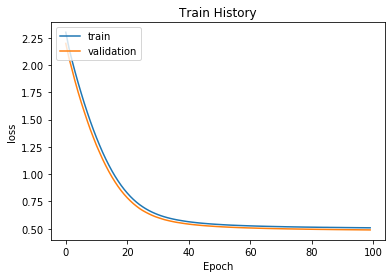

In [12]:
from obesity.model_evaluation import metric_array,show_train_history

show_train_history(e.model.history ,'loss','val_loss')

In [13]:
from tensorflow.keras.models import load_model
autoencoder_path = 'model/autoencoder_991_001.h5'
e = load_model(autoencoder_path)

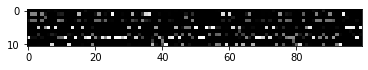

In [14]:
import matplotlib.pyplot as plt
plt.imshow(e(valid_data_onehot[1].reshape(1,-1,11))[0].numpy().transpose()[:,:100])
plt.gray()

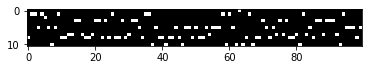

In [15]:
plt.imshow(valid_data_onehot[1].reshape(1,-1,11)[0].transpose()[:,:100])
plt.gray()

(array([4.40000e+01, 6.10000e+01, 5.20000e+01, 7.10000e+01, 7.50000e+01,
        7.40000e+01, 7.60000e+01, 8.90000e+01, 7.70000e+01, 1.22000e+02,
        9.30000e+01, 9.50000e+01, 1.06000e+02, 1.29000e+02, 1.14000e+02,
        1.56000e+02, 1.66000e+02, 1.27000e+02, 1.54000e+02, 1.85000e+02,
        1.89000e+02, 2.59000e+02, 2.73000e+02, 3.16000e+02, 3.13000e+02,
        2.37000e+02, 1.84000e+02, 1.27000e+02, 1.13000e+02, 1.35000e+02,
        1.27000e+02, 9.90000e+01, 1.32000e+02, 1.21000e+02, 1.50000e+02,
        1.48000e+02, 1.48000e+02, 1.41000e+02, 1.83000e+02, 1.64000e+02,
        2.07000e+02, 2.06000e+02, 2.24000e+02, 2.97000e+02, 3.94000e+02,
        4.06000e+02, 6.22000e+02, 8.64000e+02, 9.87000e+02, 2.02300e+03,
        1.07971e+05, 2.39500e+03, 1.48000e+03, 1.07700e+03, 7.85000e+02,
        6.69000e+02, 5.80000e+02, 4.87000e+02, 4.99000e+02, 4.15000e+02,
        3.95000e+02, 3.62000e+02, 3.40000e+02, 3.34000e+02, 3.34000e+02,
        2.80000e+02, 2.93000e+02, 3.36000e+02, 3.22

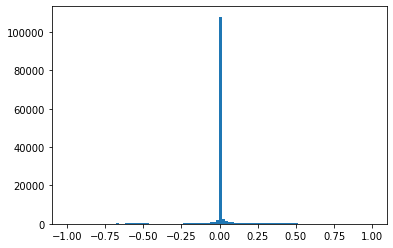

In [16]:
p = e(train_data_onehot[1].reshape(1,-1,11)).numpy().reshape(-1)
a = train_data_onehot[1].reshape(-1)
plt.hist(p-a,100)